In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import zipfile

#zip_ref = zipfile.ZipFile("/content/drive/My Drive/CC_Thesis_DP/datasets/imagenet/val_images.zip", 'r')
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Research/Thesis/CC_Thesis_DP/datasets/imagenet/val_images.zip", 'r')

for i in range(50000):

  if i <45000:
    zip_ref.extract(zip_ref.infolist()[i], path = "/content/imagenet/Train")
  else:
    zip_ref.extract(zip_ref.infolist()[i], path = "/content/imagenet/Test")

#zip_ref.extractall("/content/CC_Thesis_DP/datasets/imagenet/")
zip_ref.close()

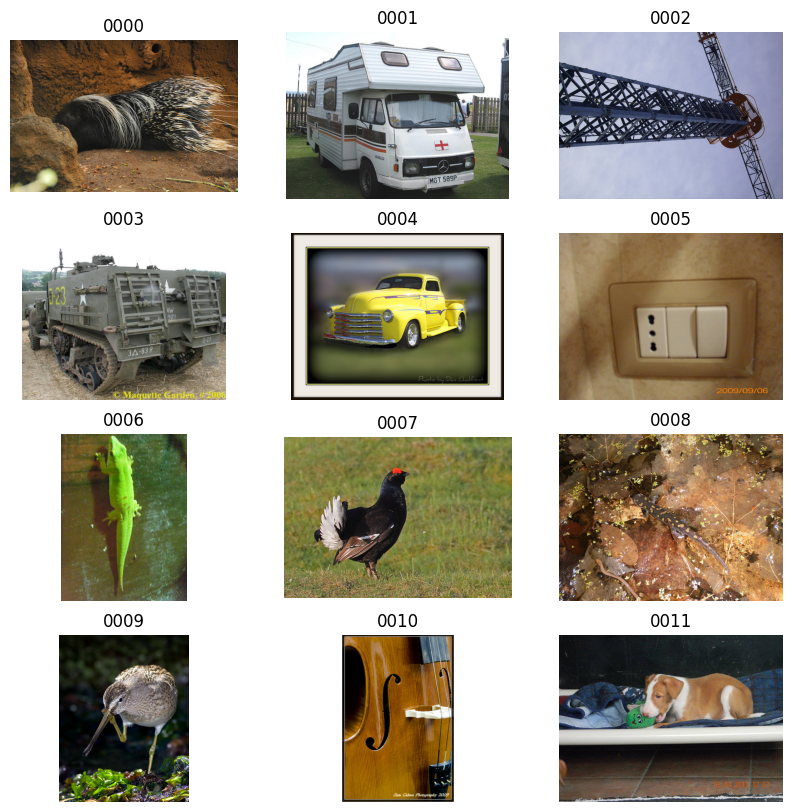

In [9]:
# prompt: Show some image from each class

import glob
import matplotlib.pyplot as plt
from PIL import Image
import random

# Get a list of all the image files in the dataset.
images = glob.glob('/content/imagenet/Train/val_images/*.JPEG')

# Create a figure with subplots to display the images.
fig, axs = plt.subplots(4, 3, figsize=(10, 10))

# Select a random image from each class and display it.
ids = sorted(set([image.split('/')[-1][-10:-6] for image in images]))
for i, cls in enumerate(ids[0:12]):
  class_images = [image for image in images if image.split('/')[-1][-10:-6] == cls]
  random_image = random.choice(class_images)
  image = Image.open(random_image)
  axs[i // 3, i % 3].imshow(image)
  axs[i // 3, i % 3].set_title(cls)
  axs[i // 3, i % 3].axis('off')

# Show the plot.
plt.show()

In [10]:
# prompt: Use keras to load a pretrained convnext model

import keras
from keras.applications import ConvNeXtTiny
cn_model = ConvNeXtTiny(weights='imagenet')


114735104/114735104 [==============================] - 1s 0us/step


In [11]:
# Create a model that applies cn_model to the input, but takes the output
# of the previous to last layer and normalize it

notop_model = keras.Model(inputs=cn_model.inputs, outputs=cn_model.layers[-2].output)

x = notop_model.output
x = keras.layers.UnitNormalization()(x)
emb_model = keras.Model(inputs=notop_model.inputs, outputs=x)


In [12]:
# prompt: Load an image and apply both cn_model and emb_model
from keras.applications.resnet50 import decode_predictions
import numpy as np
image = Image.open('/content/imagenet/Train/val_images/ILSVRC2012_val_00000001.JPEG')
image = image.resize((224, 224))
# image = np.array(image) / 255.0 # WARNING: This is not needed since ConvNext preprocess the input

cn_output = cn_model.predict(np.expand_dims(image, axis=0))
emb_output = emb_model.predict(np.expand_dims(image, axis=0))


print('Class prediction:', np.argmax(cn_output), decode_predictions(cn_output, top=5))
print('Embedding shape:', emb_output.shape)


35363/35363 [==============================] - 0s 0us/step
Class prediction: 65 [[('n01751748', 'sea_snake', 0.9370061), ('n01744401', 'rock_python', 0.0054384526), ('n02526121', 'eel', 0.0020061706), ('n01737021', 'water_snake', 0.0019597998), ('n01740131', 'night_snake', 0.0007720486)]]
Embedding shape: (1, 768)


In [14]:
#file = '/content/drive/MyDrive/CC_Thesis_DP/datasets/imagenet/val_labels_onlynums.txt'
file = '/content/drive/MyDrive/Research/Thesis/CC_Thesis_DP/datasets/imagenet/val_labels_onlynums.txt'
#file.read_text()

    # Open the file in "read" mode ('r')
with open(file, 'r') as text:
    textfile = text.read()


textfile = textfile.split('\n')
textfile.pop()

labels = [eval(i) for i in textfile]

In [ ]:
labels


In [50]:
import tensorflow as tf

train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/imagenet/Train/val_images',
    labels = labels[:45000],
    label_mode='int',
    batch_size=256,
    image_size=(224, 224),
    shuffle=False)

embds = []
y_labels = []
y_preds = []
for batch in iter(train_ds):
    print('.')  # progress bar
    imgs, y = batch
    emb = emb_model(imgs)
    embds.extend(emb)

Found 45000 files belonging to 1000 classes.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [51]:
embdsarr = np.array(embds)
embdsarr = embdsarr / np.linalg.norm(embdsarr, axis= -1, keepdims= True)
embdsarr.shape

(45000, 768)

In [52]:
np.linalg.norm(embdsarr[100])

1.0

In [53]:
# Create a KNN classifier with the weights

from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(embdsarr, labels[:embdsarr.shape[0]])

# test it with the embedding of the previous image
emb_output = emb_output / np.linalg.norm(emb_output)
distances, indices = knn_model.kneighbors(emb_output)
print(distances, indices)
pred_label = knn_model.predict(emb_output)
print(pred_label)

[[0.29581551 0.57491626 0.7214928  0.78622015 0.86071316]] [[    0 35364   323 21258 44383]]
[65]


In [54]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/imagenet/Test/val_images',
    labels = labels[45000:],
    label_mode='int',
    batch_size=256,
    image_size=(224, 224),
    shuffle=False)

Found 5000 files belonging to 995 classes.


In [56]:
y_labels = []
y_preds = []
i = 0
for i, batch in enumerate(iter(test_ds)):
    if i % 10 == 0:
         print('.')  # progress bar
    imgs, y = batch
    emb = emb_model(imgs)
    emb = emb / np.linalg.norm(emb, axis= -1, keepdims= True)
    distances, indices = knn_model.kneighbors(emb)
    y_labels.extend(y)
    y_preds.extend(np.take(labels, indices[:, 0]))



.
.


In [57]:
from sklearn.metrics import classification_report, accuracy_score

y_labels = np.array(labels[45000:])
y_preds = np.array(y_preds)

print(classification_report(y_labels, y_preds, labels=np.unique(y_labels)))
print(f'Accuracy: {accuracy_score(y_labels, y_preds):.2f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.82      0.90      0.86        10
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         7
           5       1.00      0.80      0.89         5
           6       0.67      1.00      0.80         2
           7       0.80      0.57      0.67         7
           8       0.71      0.83      0.77         6
           9       1.00      1.00      1.00         6
          10       1.00      0.89      0.94         9
          11       0.67      1.00      0.80         2
          12       0.75      1.00      0.86         6
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         5
          15       1.00      0.50      0.67         4
          16       1.00      1.00      1.00         5
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
